In [1]:
import pandas as pd

url = 'https://raw.githubusercontent.com/JeanFraga/DS8-Build_Week-1/master/notebooks/Restaurant_Consumer_Data_merged'

df = pd.read_csv(url)
print(df.shape)
df.head()

(1161, 116)


,userid,placeid,rating,food_rating,service_rating,ulatitude,ulongitude,smoker,drink_level,dress_preference,...,rcuisine_seafood,rcuisine_steaks,rcuisine_sushi,rcuisine_vegetarian,rtotal_cuisine,accepts_amex,accepts_debit,accepts_cash,accepts_mastercard,accepts_visa
0,u1077,135085,2,2,2,22.156469,-100.985540,False,social drinker,elegant,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0
1,u1077,135038,2,2,1,22.156469,-100.985540,False,social drinker,elegant,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,u1077,132825,2,2,2,22.156469,-100.985540,False,social drinker,elegant,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,u1077,135060,1,2,2,22.156469,-100.985540,False,social drinker,elegant,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,u1068,135104,1,1,2,23.752269,-99.168605,False,casual drinker,informal,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0


In [2]:
from sklearn.model_selection import train_test_split

target1 = 'rating'
target2 = 'food_rating'
target3 = 'service_rating'

X = df.drop(columns=[target1, target2, target3])
y1 = df[target1]
y2 = df[target2]
y3 = df[target3]

X_train, X_test,y1_train, y1_test,y2_train, y2_test,y3_train, y3_test= train_test_split(X,y1,y2,y3, test_size=0.2, random_state=7)
X_train.shape, X_test.shape,y1_train.shape, y1_test.shape,y2_train.shape, y2_test.shape,y3_train.shape, y3_test.shape

((928, 113), (233, 113), (928,), (233,), (928,), (233,), (928,), (233,))

In [3]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

dummy = DummyClassifier(strategy= 'stratified',random_state=7)
y1_pred = dummy.fit(X_train, y1_train).predict(y1_test)
print(y1_train.value_counts(normalize=True))
print(classification_report(y1_test, y1_pred))

2    0.399784
1    0.375000
0    0.225216
Name: rating, dtype: float64
              precision    recall  f1-score   support

           0       0.22      0.29      0.25        45
           1       0.31      0.36      0.33        73
           2       0.47      0.37      0.41       115

    accuracy                           0.35       233
   macro avg       0.33      0.34      0.33       233
weighted avg       0.37      0.35      0.35       233



In [4]:
dummy = DummyClassifier(strategy= 'stratified',random_state=7)
y1_pred = dummy.fit(X, y1).predict(y1)
print(y1.value_counts(normalize=True))
print(classification_report(y1, y1_pred))

2    0.418605
1    0.362618
0    0.218777
Name: rating, dtype: float64
              precision    recall  f1-score   support

           0       0.20      0.19      0.19       254
           1       0.37      0.38      0.37       421
           2       0.43      0.43      0.43       486

    accuracy                           0.36      1161
   macro avg       0.33      0.33      0.33      1161
weighted avg       0.36      0.36      0.36      1161



In [10]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
import category_encoders as ce
from sklearn.pipeline import make_pipeline

model = XGBClassifier(
    n_estimators=1000,
    max_depth=2,
    learning_rate=0.05,
    n_jobs=-1,
    tree_method = 'hist'
)

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    model
)

cross_val_score(pipeline, X_train, y1_train, 
                scoring='accuracy', cv=10, n_jobs=-1)

array([0.54255319, 0.65591398, 0.5483871 , 0.61290323, 0.56989247,
       0.50537634, 0.51612903, 0.5483871 , 0.68478261, 0.52747253])

In [8]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold

model = XGBClassifier()

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    model
)

parameters = {'xgbclassifier__nthread':[8],
              'xgbclassifier__learning_rate': [.05], 
              'xgbclassifier__max_depth': [2,4,8,16],
              'xgbclassifier__min_child_weight': [4,2],
              'xgbclassifier__subsample': [0.5],
              'xgbclassifier__colsample_bytree': [0.5],
              'xgbclassifier__n_estimators': [1000], 
              'xgbclassifier__tree_method': ['hist']
             }

clf = GridSearchCV(pipeline, parameters, n_jobs=-1, 
                   cv=StratifiedKFold(n_splits=5, shuffle=True), 
                   scoring='accuracy',
                   verbose=2, refit=True,return_train_score=True)
clf.fit(X_train, y1_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  5.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('ordinalencoder',
                                        OrdinalEncoder(cols=None,
                                                       drop_invariant=False,
                                                       handle_missing='value',
                                                       handle_unknown='value',
                                                       mapping=None,
                                                       return_df=True,
                                                       verbose=0)),
                                       ('xgbclassifier',
                                        XGBClassifier(base_score=0.5,
                                                      booster='...
             param_grid={'xgbclassifier__colsample_bytree': [0.5],
   

In [9]:
print(clf.best_params_)
print(clf.best_score_)
print(clf.score(X_test, y=y1_test))

{'xgbclassifier__colsample_bytree': 0.5, 'xgbclassifier__learning_rate': 0.05, 'xgbclassifier__max_depth': 2, 'xgbclassifier__min_child_weight': 4, 'xgbclassifier__n_estimators': 1000, 'xgbclassifier__nthread': 8, 'xgbclassifier__subsample': 0.5, 'xgbclassifier__tree_method': 'hist'}
0.5592672413793104
0.6223175965665236


In [10]:
y1_clf_pred = clf.predict(X)
print(classification_report(y1, y1_clf_pred))

precision    recall  f1-score   support

           0       0.88      0.66      0.75       254
           1       0.71      0.75      0.73       421
           2       0.76      0.81      0.78       486

    accuracy                           0.76      1161
   macro avg       0.78      0.74      0.76      1161
weighted avg       0.76      0.76      0.76      1161



In [46]:
import joblib
import os
os.chdir('C:/Users/serga/Documents/GitHub/DS8-Build_Week-1/assets/')
joblib.dump(clf, 'xgboost_model_y1.joblib')

['xgboost_model_y1.joblib']

In [12]:
from joblib import load
import plotly.express as px
import os
import pandas as pd
# os.chdir('assets/')
pipeline1 = load('xgboost_model_y1.joblib.compressed')

def feature_importance_per_rating(what_pipeline):

    importances = pd.Series(what_pipeline.best_estimator_.named_steps['xgbclassifier'].feature_importances_, X.columns)
    n=25
    importances = importances.sort_values()[-n:]
    importances = importances.to_frame().reset_index()
    importances.columns=['features','importance']
    # fig = 
    return px.bar(importances,y='features',x='importance',title=f'Top {n} features',  orientation='h',width=700, height=700)

feature_importance_per_rating(pipeline1)

### This here is my pdp plot from the website

(<Figure size 4500x4500 with 4 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x2c897695dc8>,
  'pdp_ax': [<matplotlib.axes._subplots.AxesSubplot at 0x2c8974d76c8>,
   <matplotlib.axes._subplots.AxesSubplot at 0x2c8972f85c8>]})

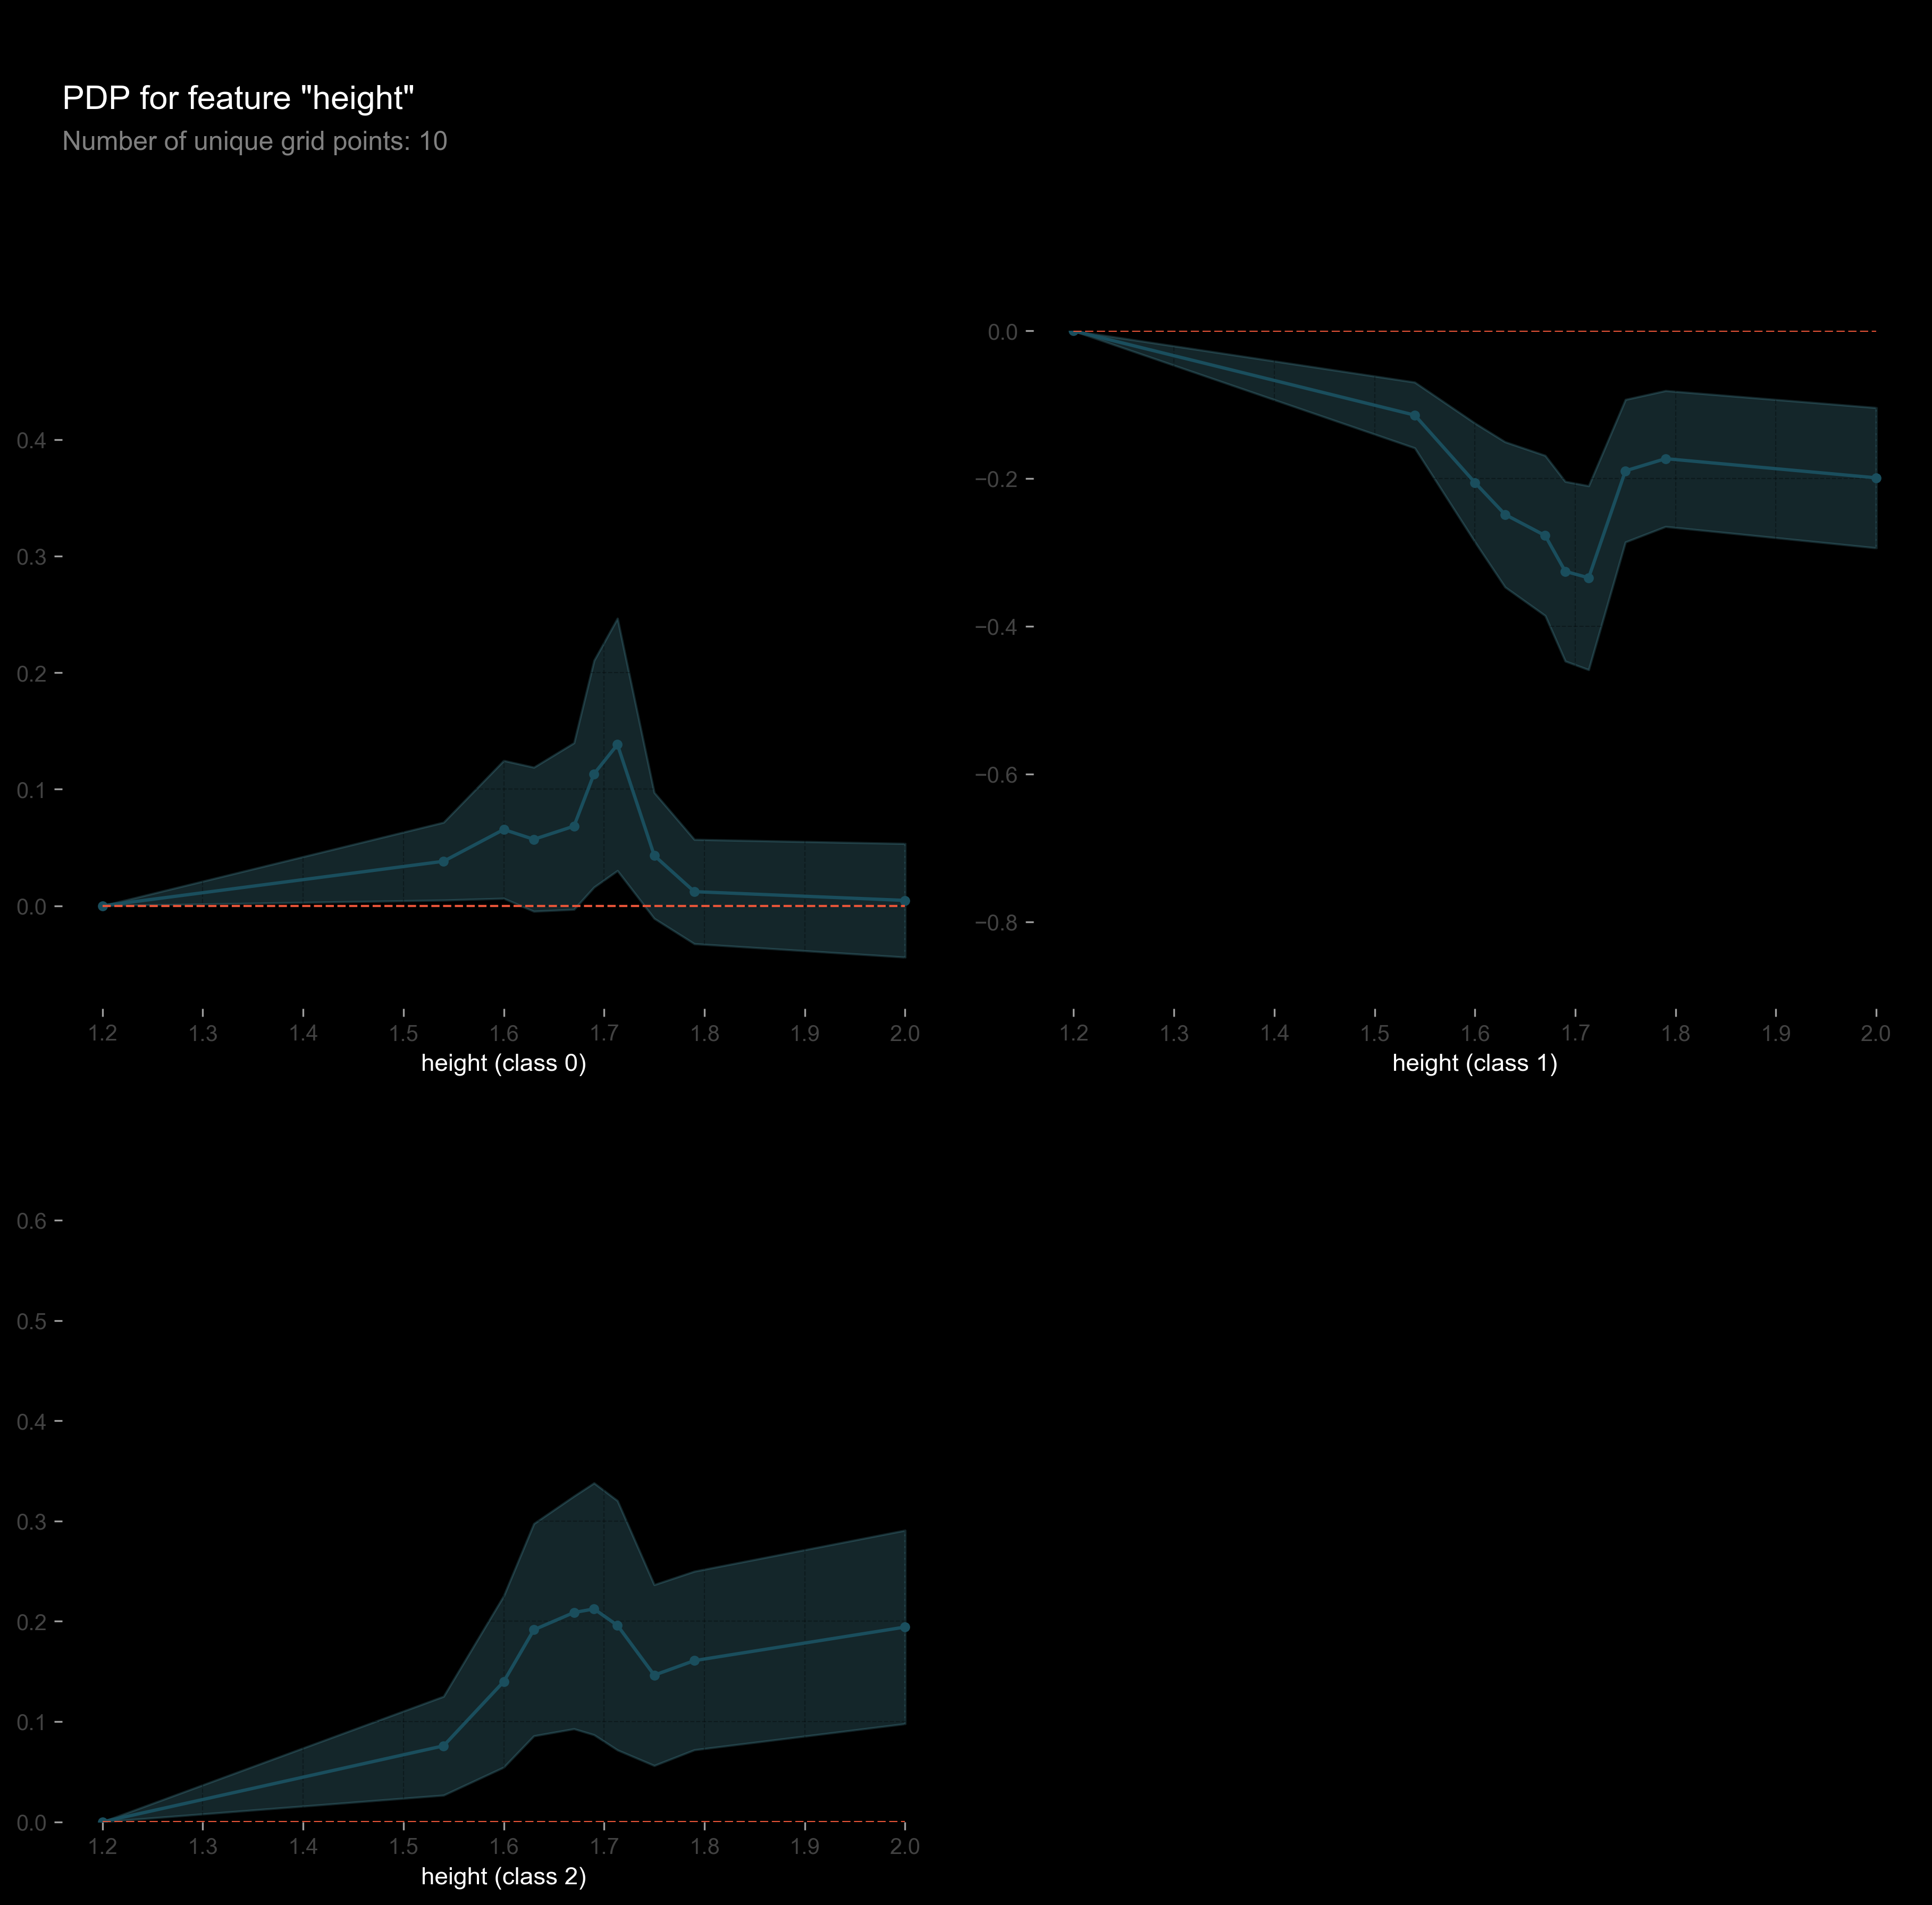

In [45]:
from pdpbox.pdp import pdp_isolate, pdp_plot
import matplotlib.pyplot as plt
feature = 'height'
plt.rcParams['figure.dpi'] = 300
isolated = pdp_isolate(
    model=pipeline1.best_estimator_, 
    dataset=X, 
    model_features=X.columns, 
    feature=feature
)
pdp_plot(isolated, feature_name=feature)